# Analysis of the bus data collected by data-collector

Comparison between two intervals

    1. 10am-11am (morning-noon)
    2. 2.30am-3.30am (night)

## Preparation

### Load data from a file generated by data collector

In [3]:
import json

def load_data(file):
    with open(file, 'r') as json_file:
        return json.load(json_file)

day_data = load_data('data/10-11.json')
night_data = load_data('data/2.30-3.30.json')

### Lets define a method that calculates distance between 2 points on earth

In [4]:
import numpy as np

def calculate_distance(lat_a, lon_a, lat_b, lon_b):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude to radians
    lat_a, lon_a, lat_b, lon_b = np.radians([lat_a, lon_a, lat_b, lon_b])
    
    # Calculate the difference in latitude and longitude
    dlat = lat_b - lat_a
    dlon = lon_b - lon_a
    
    # Apply the Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat_a) * np.cos(lat_b) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

### Some tests

In [5]:
def test_distance_between_the_same_points():
    lat_a, lon_a = 52.52, 13.405
    
    expected_distance = 0
    calculated_distance = calculate_distance(lat_a, lon_a, lat_a, lon_a)
    assert np.isclose(calculated_distance, expected_distance, atol=0.001)
    
def test_distance_between_cities():
    lat_a, lon_a = 52.52, 13.405  # Berlin
    lat_b, lon_b = 48.8566, 2.3522  # Paris
    
    expected_distance = 878.7
    calculated_distance = calculate_distance(lat_a, lon_a, lat_b, lon_b)
    assert np.isclose(calculated_distance, expected_distance, atol=10)

In [6]:
test_distance_between_the_same_points()
test_distance_between_cities()

## Process data

### For each point calculate speed of the bus at that moment

In [7]:
import pandas as pd

def calculate_speed(df):
    df = df.copy()
    
    # Convert time to pandas time type.
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

    # Drop rows with missing or invalid datetime.
    df = df.dropna(subset=['Time'])

    # Sort by vehicles and time.
    df.sort_values(by=['VehicleNumber', 'Time'], inplace=True)

    # Calculate distance between two consecutive points for each vehicle.
    df['distance'] = np.hstack(df.groupby('VehicleNumber')
                                 .apply(lambda x: calculate_distance(x['Lat'],
                                                                     x['Lon'],
                                                                     x['Lat'].shift(),
                                                                     x['Lon'].shift()))
                                 .values)

    # Calculate time difference between consecutive points (in hours).
    df['time_diff'] = df.groupby('VehicleNumber')['Time'].diff().dt.total_seconds() / 3600

    # Calculate speed (in km/h)
    df['speed'] = df['distance'] / df['time_diff']

    # Remove points with no speed.
    df = df.dropna(subset=['speed'])
    
    return df

### It's the most important part of the code. We need to test it.

In [8]:
def test_calculate_speed():
    lat_a = 52.179989
    lon_a = 21.0238
    lat_b = 52.184197
    lon_b = 20.9608521
    
    dist = calculate_distance(lat_a, lon_a, lat_b, lon_b)
    expected_speed = dist / 0.5 # we take half an our interval
    mock_data = [
        {
            "Time": "2024-02-20 20:01:56",
            "VehicleNumber": "9342",
            "Lines": "739",
            "Brigade": "4",
            "Lat": lat_a,
            "Lon": lon_a
        },
        {
            "Time": "2024-02-20 20:31:56",
            "VehicleNumber": "9342",
            "Lines": "739",
            "Brigade": "4",
            "Lat": lat_b,
            "Lon": lon_b
        }
    ]
    
    df = pd.DataFrame(mock_data)
    
    df = calculate_speed(df)
    
    assert 'speed' in df.columns
    
    index = df['speed'].first_valid_index()
    speed = df.at[index, 'speed']
    
    assert expected_speed == speed

In [9]:
test_calculate_speed()

### After testing we can use it on our data

In [10]:
df_day = pd.DataFrame(day_data)
df_night = pd.DataFrame(night_data)

import cProfile
from pstats import Stats

profiler = cProfile.Profile()

profiler.enable()
df_day = calculate_speed(df_day)
df_night = calculate_speed(df_night)
profiler.disable()

stats = Stats(profiler)

### We can check some rows.

In [11]:
df_day

,Time,VehicleNumber,Lines,Brigade,Lat,Lon,distance,time_diff,speed
23500,2024-02-29 10:06:20,1001,311,501,52.221523,21.093581,0.030284,0.001389,21.804381
295091,2024-02-29 10:06:45,1001,311,501,52.221117,21.096941,0.233352,0.006944,33.602623
198072,2024-02-29 10:07:10,1001,311,501,52.221271,21.097911,0.068226,0.006944,9.824534
175593,2024-02-29 10:07:20,1001,311,501,52.221460,21.098713,0.058562,0.002778,21.082179
120639,2024-02-29 10:07:40,1001,311,501,52.222384,21.100732,0.171620,0.005556,30.891657
...,...,...,...,...,...,...,...,...,...
157247,2024-02-29 11:12:43,9954,114,6,52.307369,20.930101,0.108616,0.002778,39.101800
7019,2024-02-29 11:13:08,9954,114,6,52.306236,20.932081,0.184374,0.006944,26.549789
307258,2024-02-29 11:13:18,9954,114,6,52.305626,20.933172,0.100513,0.002778,36.184810
195833,2024-02-29 11:13:31,9954,114,6,52.305344,20.933657,0.045504,0.003611,12.601153


In [18]:
df_night

,Time,VehicleNumber,Lines,Brigade,Lat,Lon,distance,time_diff,speed
26202,2024-02-29 02:57:23,1031,163,03,52.185993,20.997959,0.003063,7.680556,0.000399
67518,2024-02-29 02:57:34,1031,163,03,52.185980,20.997949,0.001631,0.003056,0.533889
8691,2024-02-29 02:57:44,1031,163,03,52.185975,20.997953,0.000619,0.002778,0.222930
9512,2024-02-29 02:58:07,1031,163,03,52.185964,20.997957,0.001193,0.006389,0.186740
37266,2024-02-29 02:58:19,1031,163,03,52.185959,20.997955,0.000625,0.003333,0.187542
...,...,...,...,...,...,...,...,...,...
75749,2024-02-29 02:50:51,9954,186,12,52.279259,20.873817,0.000489,0.002778,0.176173
27195,2024-02-29 02:51:02,9954,186,12,52.279255,20.873812,0.000560,0.003056,0.183253
82941,2024-02-29 02:51:27,9954,186,12,52.279247,20.873812,0.000890,0.006944,0.128097
2826,2024-02-29 02:51:37,9954,186,12,52.279251,20.873808,0.000521,0.002778,0.187711


### And we can check the profiling results

In [19]:
stats.print_stats()

         1680866 function calls (1673144 primitive calls) in 1.247 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
    14417    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
        4    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
     7185    0.001    0.000    0.001    0.000 {method 'items' of 'dict' objects}
        3    0.000    0.000    0.000    0.000 {built-in method fromkeys}
        8    0.010    0.001    0.010    0.001 {method 'clear' of 'dict' objects}
        4    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
    15019    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
       54    0.000    0.000    0.000    0.000 {method 'insert' of 'list' objects}
        7    0.000    0

## Analysis of speeds of the buses

### How many buses have exceeded 50km/h?

In [35]:
import matplotlib.pyplot as plt

# Get all points with exceeded speed limit.
df_day_exceeded = df_day[df_day['speed'] > 50]
df_night_exceeded = df_night[df_night['speed'] > 50]

def plot_how_many_buses_exceeded_50(df, df_exceeded, day_time):
    # Total number of buses
    number_of_buses_total = df["VehicleNumber"].nunique()

    # Number of buses that exceeded the speed limit.
    number_of_buses_exceeded = df_exceeded["VehicleNumber"].nunique()

    # Plot.
    plt.figure(figsize=(8, 6))
    plt.bar(['Below 50 km/h', 'Above 50 km/h'],
            [number_of_buses_total - number_of_buses_exceeded, number_of_buses_exceeded],
            color=['green', 'red'])
    plt.xlabel('Speed')
    plt.ylabel('Number of Buses')
    plt.title(f"Distribution of buses by their top speed at {day_time}.")
    plt.show()

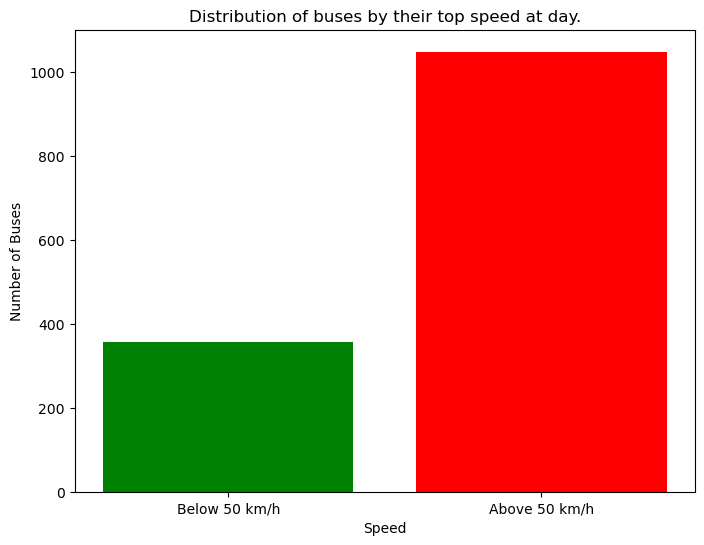

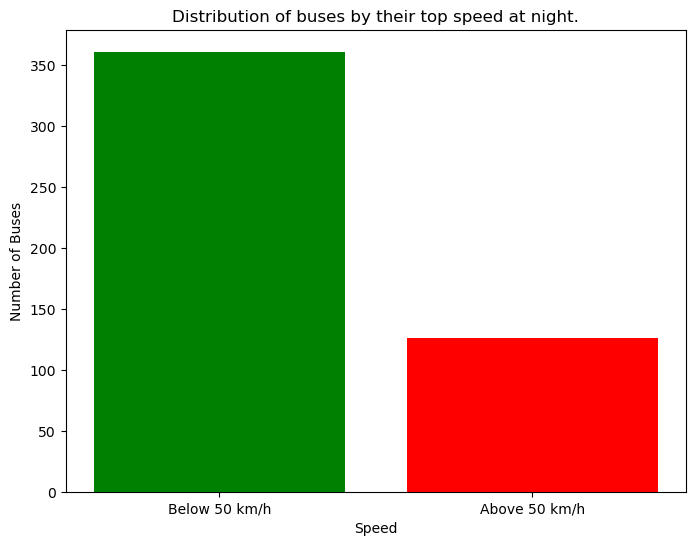

In [36]:
plot_how_many_buses_exceeded_50(df_day, df_day_exceeded, 'day')
plot_how_many_buses_exceeded_50(df_night, df_night_exceeded, 'night')

### In what locations more than 50% of buses have exceeded the speed limit?

Lets define a location as a square with a middle point `p` and side `a`

### Find locations

In [40]:
def find_locations(df, df_exceeded):
    # Side of the square in degrees on earth surface
    a = 0.002

    # Percentage
    p = 50

    # Middle points of locations with high percentage of speeding.
    locations = []

    # Lets use R-Tree to count quiqly the number of points within a square.

    from rtree import index

    p_index_all = index.Index()
    p_index_exceeded = index.Index()

    for idx, row in df.iterrows():
        lat = row['Lat']
        lon = row['Lon']
        p_index_all.insert(idx, (lon, lat, lon, lat))

    for idx, row in df_exceeded.iterrows():
        lat = row['Lat']
        lon = row['Lon']
        p_index_exceeded.insert(idx, (lon, lat, lon, lat))

    for idx, row in df.iterrows():
        lat = row['Lat']
        lon = row['Lon']

        # All points within the square centered in the point.
        neighbors_all = list(p_index_all.intersection((lon - a/2, lat - a/2, lon + a/2, lat + a/2)))

        # Points with exceeded speed limit within the square centered in the point.
        neighbors_exceeded = list(
            p_index_exceeded.intersection((lon - a/2, lat - a/2, lon + a/2, lat + a/2)))


        if (len(neighbors_exceeded) / len(neighbors_all)) * 100 > p:
            locations.append((lat, lon))
    
    return locations

In [41]:
profiler.clear()

profiler.enable()
locations_day = find_locations(df_day, df_day_exceeded)
locations_night = find_locations(df_night, df_night_exceeded)
profiler.disable()

In [42]:
print(f"Number of locations at day: {len(locations_day)}")
print(f"Number of locations at night: {len(locations_night)}")

Number of locations at day: 3166
Number of locations at night: 871


### And check the profiling results

In [43]:
stats = Stats(profiler)
stats.print_stats()

         797406629 function calls (794109105 primitive calls) in 255.955 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        6    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
        4    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        6    0.000    0.000    0.000    0.000 {built-in method fromkeys}
     4037    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
   824375    0.235    0.000    0.235    0.000 {method 'split' of 'str' objects}
   824387    0.347    0.000    1.059    0.000 {built-in method builtins.all}
       12    0.000    0.000    0.000    0.000 {built-in method builtins.any}
  1648750    0.124    0.000    0.124    0.000 {built-in method builtins.callable}
        4    0.001    0.000    0.001    0.000 {built-in method builtins.compile}
        4    0.000  

### Show them on map of Warsaw

In [49]:
from folium import folium
from folium.plugins import HeatMap

warsaw_coordinates = (52.2297, 21.0122)

def create_a_map_of_locations(locations):
    # Create a map centered around Warsaw
    map_warsaw = folium.Map(location=warsaw_coordinates, zoom_start=12)

    # Create heatmap data
    heat_data = [[point[0], point[1]] for point in locations]

    # Add heatmap layer
    HeatMap(heat_data, radius=15).add_to(map_warsaw)

    return map_warsaw

In [50]:
map_day = create_a_map_of_locations(locations_day)
map_night = create_a_map_of_locations(locations_night)

In [52]:
map_day

In [53]:
map_night

### As expected, most of the points are located on the roads with higher speed limits.

## Bonus (additional analysis prepared by me)

Based on the analysis above, we can notice that most of the buses have exceeded the speed limit. It's good to know if that result is reliable.

### Distribution of speedings

In [54]:
def plot_distribution_of_speedings(df_exceeded, day_time):
    buckets = list(range(50, 101, 10)) + [np.inf]
    speed_buckets = pd.cut(df_exceeded['speed'], bins=buckets, right=False)
    speed_counts = speed_buckets.value_counts().sort_index()

    plt.figure(figsize=(10, 8))
    plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of speedings in km/h at {day_time}.")
    plt.axis('equal') 
    plt.show()

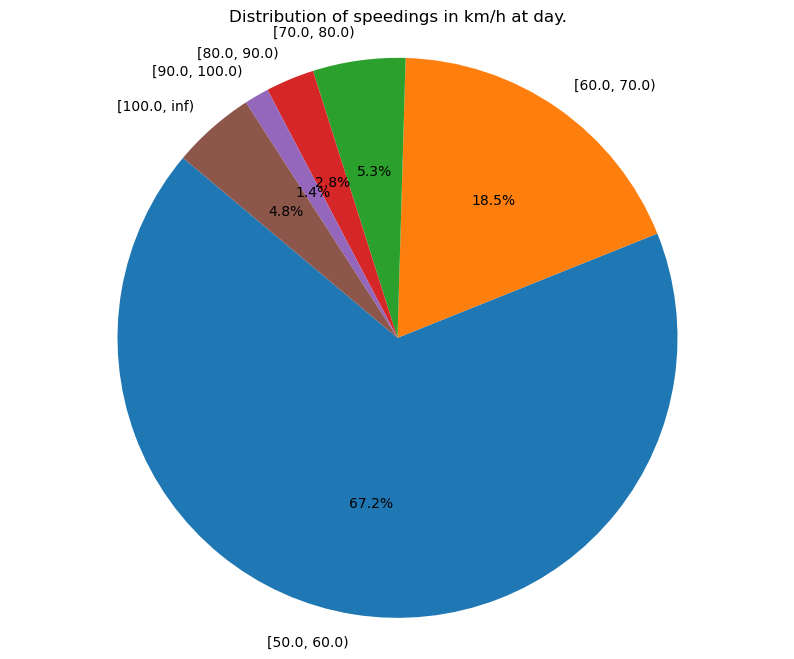

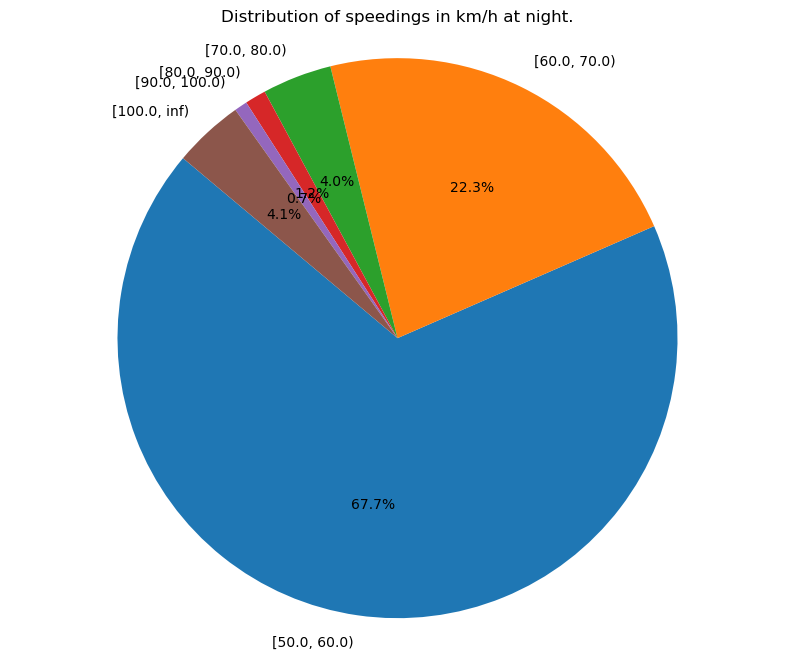

In [57]:
plot_distribution_of_speedings(df_day_exceeded, 'day')
plot_distribution_of_speedings(df_night_exceeded, 'night')

As we can see, most of the speedings are not significant, and the number in each category is decreasing. That's why we can assume that the speedings result is reliable. Nevertheless more than 3% of speedings are speedings with speed higher than 100 km/h which is not possible. It is related to the inaccuraccy of gps positions. We can easily filter that out.

### How about other speeds?

In [59]:
def plot_distribution_of_speeds(df, day_time):
    buckets = list(range(0, 51, 10))
    speed_buckets = pd.cut(df['speed'], bins=buckets, right=False)
    speed_counts = speed_buckets.value_counts().sort_index()

    plt.figure(figsize=(10, 8))
    plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of speed in km/h at {day_time}")
    plt.axis('equal') 
    plt.show()

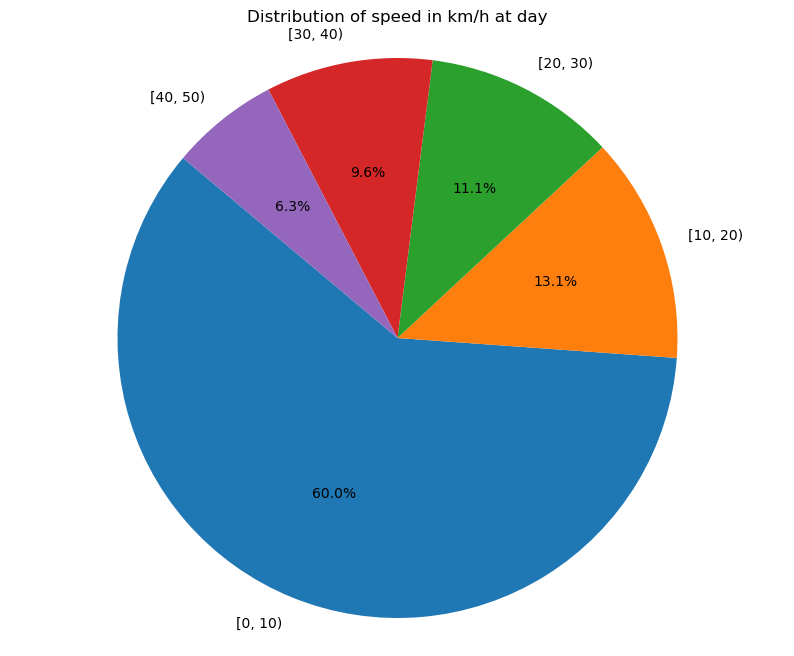

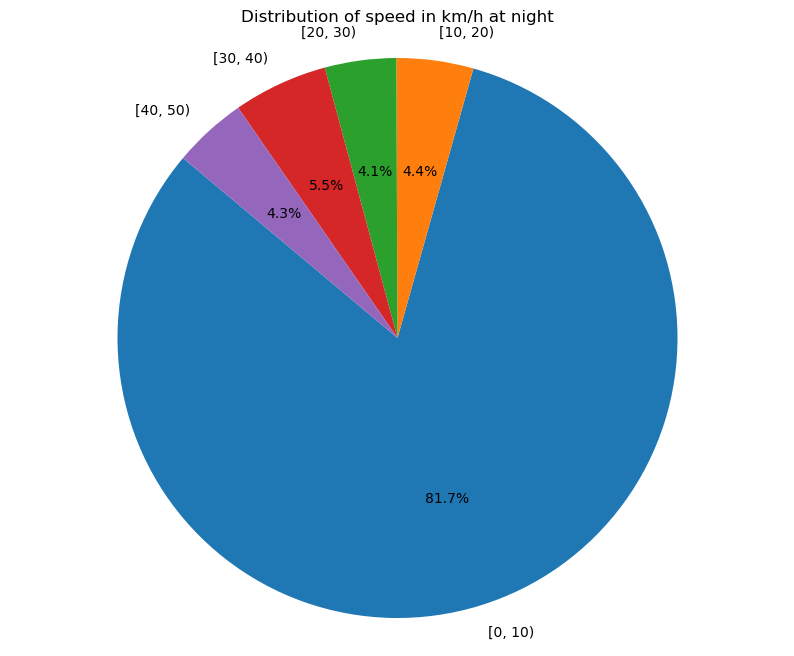

In [61]:
plot_distribution_of_speeds(df_day, 'day')
plot_distribution_of_speeds(df_night, 'night')

Most of the time buses spend in the traffic! Whats interesting more buses in night. IMO those buses just don't move.

### Lets make a ranking of the fastests lines.

In [62]:
def rank_fastest_line(df, day_time):
    # Get rid of unrealistic values
    df = df[df['speed'] <= 90]

    speeds = df.groupby('Lines')['speed'].mean()

    # Sort the speeds in descending order
    sorted_speeds = speeds.sort_values(ascending=False)

    # Select the top 5 highest speeds
    top_5_speeds = sorted_speeds.head(5)

    # Plotting
    plt.figure(figsize=(10, 6))
    top_5_speeds.plot(kind='bar', color='skyblue')
    plt.title(f"Top 5 Highest Average Speeds by Line at {day_time}")
    plt.xlabel('Lines')
    plt.ylabel('Average Speed')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

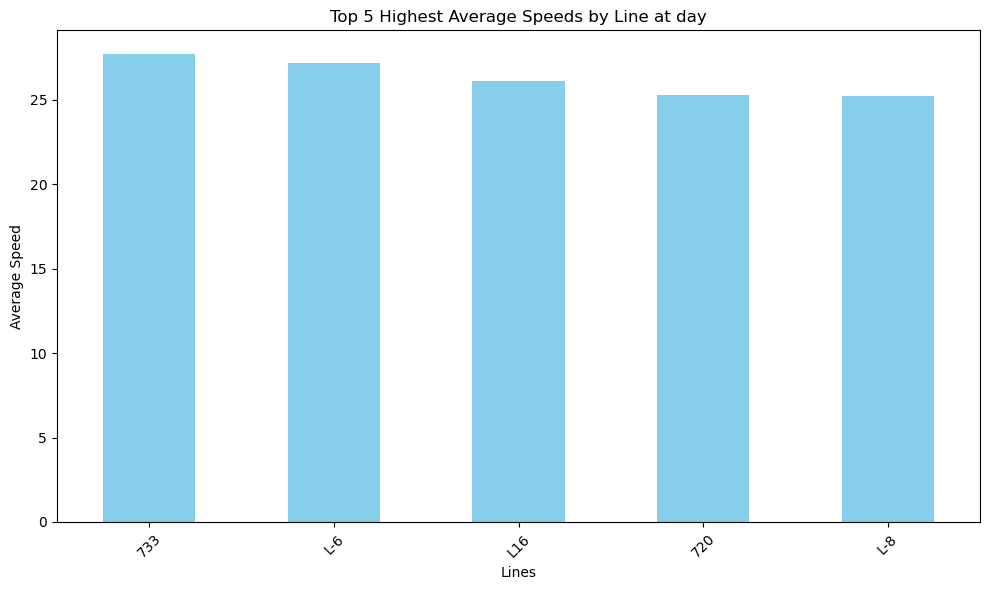

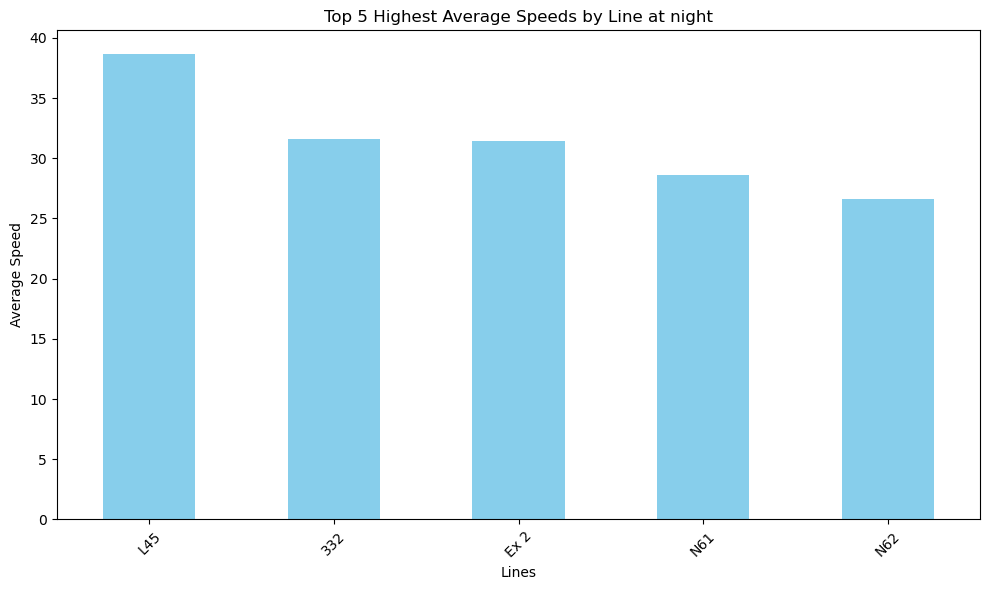

In [63]:
rank_fastest_line(df_day, 'day')
rank_fastest_line(df_night, 'night')

It looks pretty reliable. The lines listed here are not placed in the centre of Warsaw. Also we can see that buses at day are much slower than at night.

### What about the slowest ones?

In [67]:
def rank_slowest_line(df, day_time):
    # Get rid of unrealistic values
    df = df[df['speed'] >= 5]
    
    speeds = df.groupby('Lines')['speed'].mean()
    
    # Sort the speeds in ascending order
    sorted_speeds = speeds.sort_values(ascending=True)

    # Select the top 5 slowest speeds
    top_5_speeds = sorted_speeds.head(5)

    # Plotting
    plt.figure(figsize=(10, 6))
    top_5_speeds.plot(kind='bar', color='skyblue')
    plt.title(f"Top 5 Lowest Average Speeds by Line at {day_time}")
    plt.xlabel('Lines')
    plt.ylabel('Average Speed')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

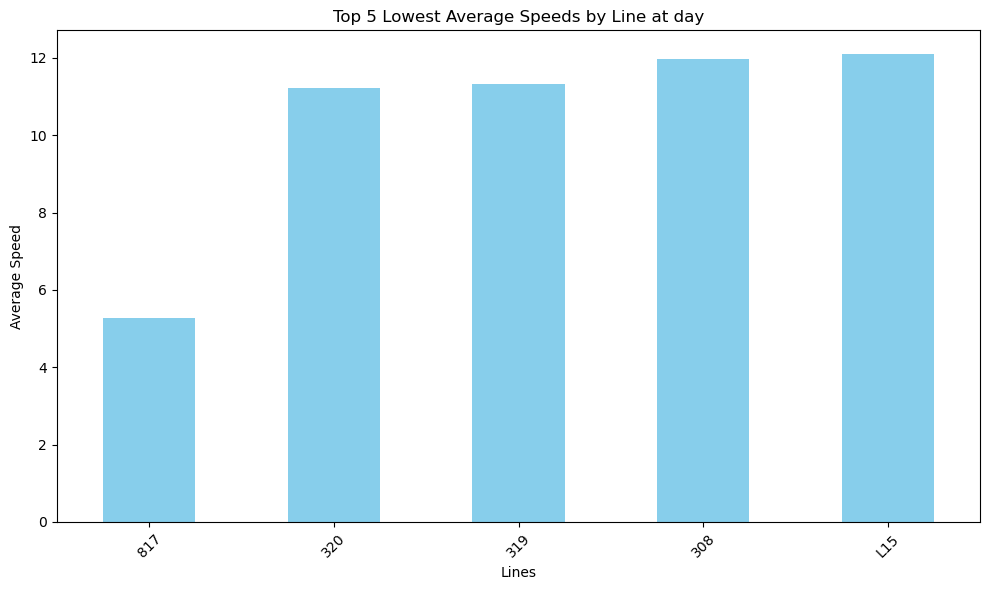

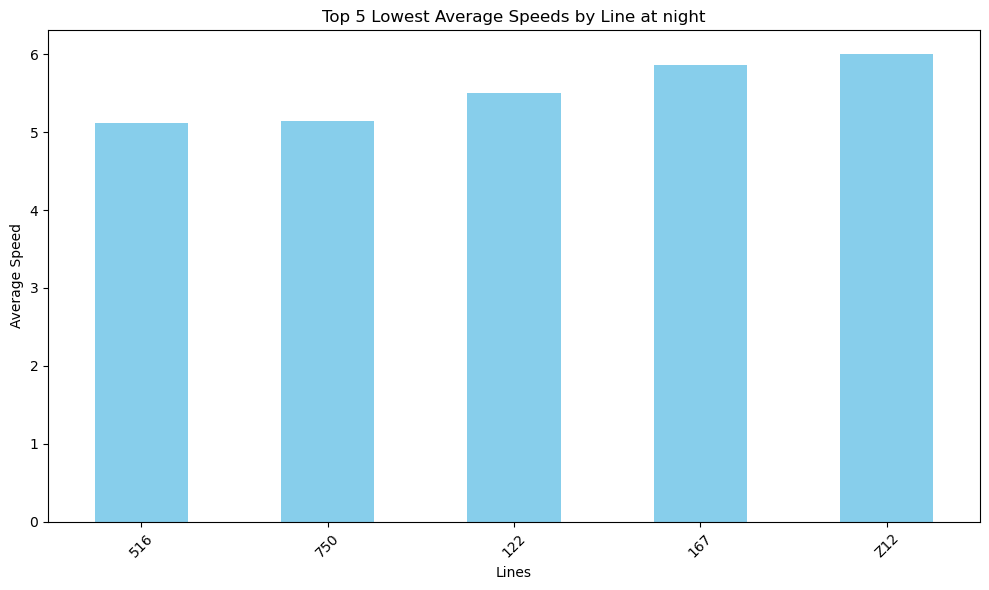

In [68]:
rank_slowest_line(df_day, 'day')
rank_slowest_line(df_night, 'night')

# THANK YOU!